In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [3]:
import tensorflow as tf

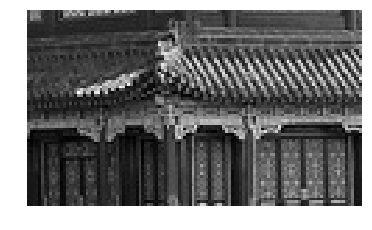

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)
plot_image(images[0, :, :, 0])

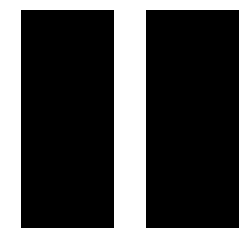

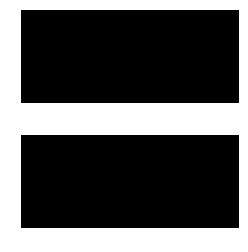

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

# Convolution layer

In [6]:
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1, 1, 1, 1], padding="SAME")

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

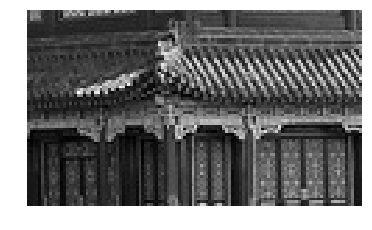

In [8]:
plot_image(images[0, :, :, 0])

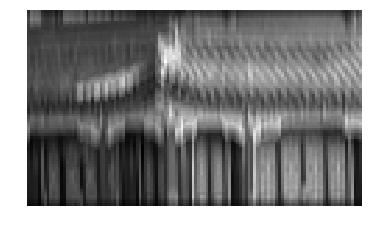

In [9]:
plot_image(output[0, :, :, 0])
plt.show()

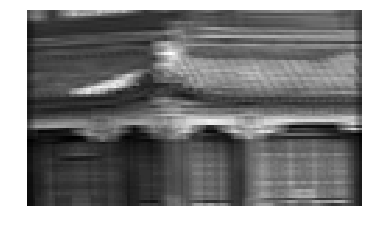

In [10]:
plot_image(output[0, :, :, 1])
plt.show()

### sample examples

In [11]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

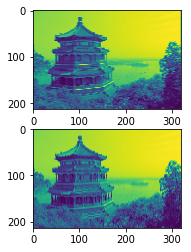

In [12]:
reset_graph()

from sklearn.datasets import load_sample_images

datasets = np.array(load_sample_images().images, dtype=np.float32)
batch_size, height, width, channels = datasets.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: datasets})
    
plt.subplot(211); plt.imshow(output[0, :, :, 1])
plt.subplot(212); plt.imshow(output[0, :, :, 0])
plt.show()

# Pooling layer

```
tf.nn.max_pol(X, 
    ksize=[batch size, height, width, channels], 
    strides, padding)
```
+ `batch size` must be equal to 1;
+ `ksize[1]` and `ksize[2]` must both be equal to 1, 
    **or** `ksize[3]` must be equal to 1

In [13]:
reset_graph()

In [14]:
batch_size, height, width, channels = datasets.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

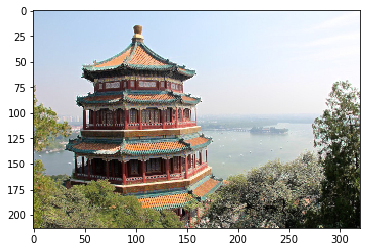

In [15]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: datasets})
    
plt.imshow(output[0].astype(np.uint8))
plt.show()

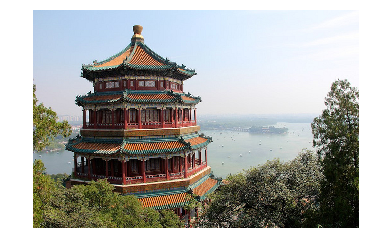

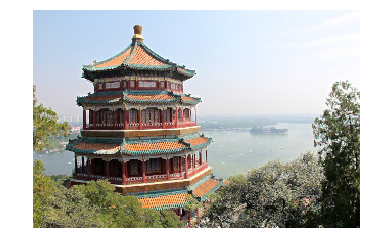

In [16]:
plot_color_image(datasets[0])
plt.show()

plot_color_image(output[0])
plt.show()

# MNIST

In [21]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                     strides=conv1_stride, padding=conv1_pad,
                     activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=(-1, pool3_fmaps * 7 * 7))
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits, name="Y_proba")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [22]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [23]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [24]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9774
1 Last batch accuracy: 0.98 Test accuracy: 0.9838
2 Last batch accuracy: 0.98 Test accuracy: 0.9801
3 Last batch accuracy: 0.98 Test accuracy: 0.9875
4 Last batch accuracy: 0.99 Test accuracy: 0.9877
5 Last batch accuracy: 1.0 Test accuracy: 0.9885
6 Last batch accuracy: 1.0 Test accuracy: 0.9883
7 Last batch accuracy: 1.0 Test accuracy: 0.9891
8 Last batch accuracy: 1.0 Test accuracy: 0.9876
9 Last batch accuracy: 1.0 Test accuracy: 0.9865
